In [2]:
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime
from typing import List, Union
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

from scipy import signal
import seaborn as sns

from pathlib import Path

import holidays

import pickle

import torch


In [3]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [4]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import utils

In [5]:
stocks1 = pd.read_table(
    "Tasas_de_interes_de_captacion_y_operaciones_del_mercado_monetario.csv",
    dtype={
        "TIPOENTIDAD": np.int64,
        "CODIGOENTIDAD": np.int64,
        "NOMBREENTIDAD": str,
        "TASA": np.float64,
        "MONTO": np.float64
    },
    parse_dates=["FECHACORTE"],
    delimiter=";",
    header=0,
    decimal=".",
    thousands=",",
    dayfirst=True
);

#stocks1.info();
df = pd.DataFrame()
#df['time_idx'] = [(i + 1) for i in range(1300)]

stocks1['FECHACORTE'] = pd.to_datetime(stocks1['FECHACORTE'], format='%m/%d/%Y')

df['FECHA'] = stocks1[(stocks1['NOMBREENTIDAD'] == 'BANCOLOMBIA ') & (stocks1['FECHACORTE'] <= '2023-04-20')]['FECHACORTE']


for i in stocks1['NOMBREENTIDAD'].unique():
    x = []
    if (len(stocks1[stocks1['NOMBREENTIDAD'] == i]) > 1300):
        for j in df['FECHA']:
            try:
                x.append(stocks1[(stocks1['NOMBREENTIDAD'] == i) & (stocks1['FECHACORTE'] == j)]['TASA'].values[0])
            except:
                x.append(0.00000001)        
        df[i] = x 

df['TASA'] = stocks1[(stocks1['NOMBREENTIDAD'] == 'BANCOLOMBIA ') & (stocks1['FECHACORTE'] <= '2023-04-20')]['TASA']
print(df)
#df = stocks1[(stocks1['NOMBREENTIDAD'] == 'BANCOLOMBIA S.A.') & (stocks1['FECHACORTE'] <= '2023-04-20')].pivot(index='FECHACORTE', columns='NOMBREENTIDAD', values='TASA')


          FECHA  BANCO DE BOGOTA   BANCO POPULAR   ITAU CORPBANCA COLOMBIA   \
3958 2018-01-02              4.77            5.08                      5.56   
3959 2018-01-03              4.82            4.96                      5.46   
3960 2018-01-04              4.58            4.85                      5.53   
3961 2018-01-05              4.66            5.06                      5.67   
3962 2018-01-09              4.77            4.85                      5.57   
...         ...               ...             ...                       ...   
5253 2023-04-14             12.20           12.15                     13.02   
5254 2023-04-17             12.52           12.27                     12.76   
5255 2023-04-18             12.34           12.48                     12.88   
5256 2023-04-19             12.04           12.04                     13.06   
5257 2023-04-20             12.28           11.99                     13.26   

      BANCOLOMBIA   BANCO GNB SUDAMERIS   BANCO BBV

In [7]:
df.head()

,FECHA,BANCO DE BOGOTA,BANCO POPULAR,ITAU CORPBANCA COLOMBIA,BANCOLOMBIA,BANCO GNB SUDAMERIS,BANCO BBVA,BANCO DE OCCIDENTE,BANCO CAJA SOCIAL,BANCO DAVIVIENDA,...,COLTEFINANCIERA,FINANCIERA DANN REGIONAL,OI COLOMBIA,FINANCIERA JURISCOOP,COOPERATIVA FINANCIERA DE ANTIOQUIA,JFK COOPERATIVA FINANCIERA,COOFINEP COOPERATIVA FINANCIERA,COTRAFA FINANCIERA,CONFIAR COOPERATIVA FINANCIERA,TASA
3958,2018-01-02,4.77,5.08,5.56,4.76,5.90,5.09,5.38,5.01,5.42,...,4.74,6.78,8.55,7.17,6.64,6.27,7.46,5.82,5.74,4.76
3959,2018-01-03,4.82,4.96,5.46,5.13,5.74,4.99,5.36,5.00,5.26,...,5.09,6.80,8.30,6.35,6.01,5.57,6.71,6.19,5.49,5.13
3960,2018-01-04,4.58,4.85,5.53,5.12,6.09,4.83,5.43,5.06,5.36,...,5.10,6.12,7.88,6.52,5.78,6.24,7.21,6.31,5.43,5.12
3961,2018-01-05,4.66,5.06,5.67,4.95,5.41,5.03,5.31,4.91,5.50,...,5.38,6.67,7.84,6.16,6.39,5.97,6.26,5.69,5.23,4.95
3962,2018-01-09,4.77,4.85,5.57,4.79,5.91,4.90,5.43,5.00,5.42,...,5.47,6.23,7.43,5.88,6.35,5.59,6.53,5.68,5.32,4.79


## Univariado Bancolombia


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import statsmodels.api as sm
rcParams['figure.figsize'] = 15, 6
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings('ignore')
#register_matplotlib_converters()

from pandas import Series
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [10]:
bancolombia = stocks1.query("NOMBREENTIDAD == 'BANCOLOMBIA '")[["FECHACORTE","TASA"]]
bancolombia = bancolombia[["FECHACORTE","TASA"]]
bancolombia.set_index("FECHACORTE", inplace=True)
bancolombia.index

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-15', '2018-01-16',
               ...
               '2023-05-10', '2023-05-11', '2023-05-12', '2023-05-15',
               '2023-05-16', '2023-05-17', '2023-05-18', '2023-05-19',
               '2023-05-23', '2023-05-24'],
              dtype='datetime64[ns]', name='FECHACORTE', length=1322, freq=None)

In [11]:
ts = bancolombia["TASA"]
ts.head()

FECHACORTE
2018-01-02    4.76
2018-01-03    5.13
2018-01-04    5.12
2018-01-05    4.95
2018-01-09    4.79
Name: TASA, dtype: float64

Text(0.5, 0, 'Fecha (Diaria)')

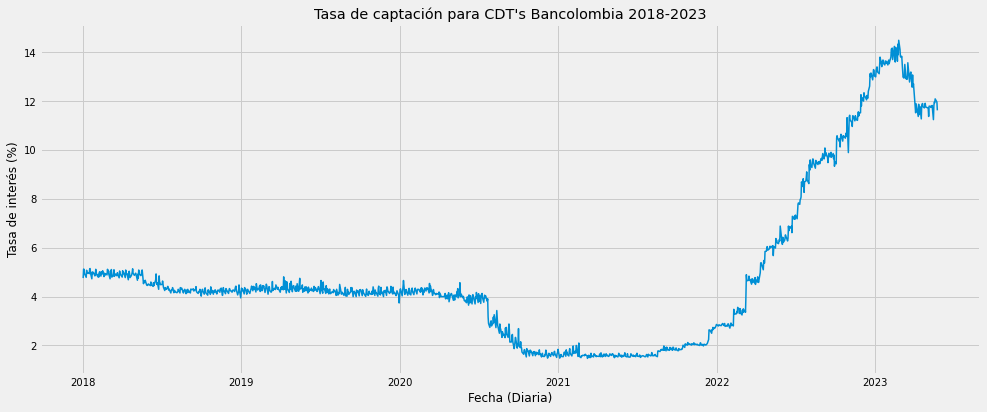

In [12]:
plt.plot(ts)
plt.title('Tasa de captación para CDT\'s Bancolombia 2018-2023'); 
plt.ylabel('Tasa de interés (%)')
plt.xlabel('Fecha (Diaria)')

In [13]:
import scipy.stats as sp ####En ocasiones puede funcionar la línea 46 sin ésta línea.
from scipy import stats
import matplotlib.pyplot as pltb
from scipy import signal

In [14]:
alp= stats.yeojohnson_normmax(ts)
alp

-0.38477777786833933

In [15]:
logts=sp.yeojohnson(bancolombia['TASA'],lmbda=alp)
bancolombia = bancolombia.assign(logts=logts)   

In [16]:
ts = bancolombia["logts"]
ts.head()

FECHACORTE
2018-01-02    1.273962
2018-01-03    1.305324
2018-01-04    1.304511
2018-01-05    1.290405
2018-01-09    1.276608
Name: logts, dtype: float64

Text(0.5, 0, 'Fecha (Diaria)')

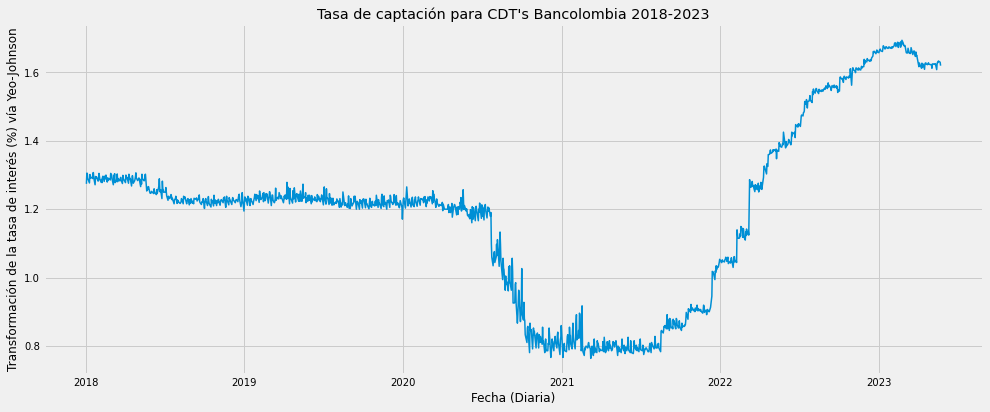

In [17]:
plt.plot(ts)
plt.title('Tasa de captación para CDT\'s Bancolombia 2018-2023'); 
plt.ylabel('Transformación de la tasa de interés (%) vía Yeo-Johnson')
plt.xlabel('Fecha (Diaria)')

(0.0, 200.0)

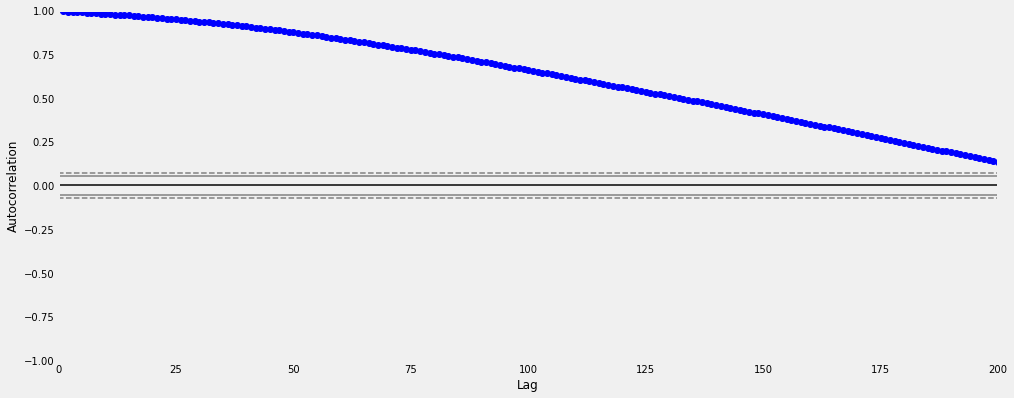

In [18]:
from pandas.plotting import autocorrelation_plot
ax =autocorrelation_plot(ts,marker="o",dashes= (1,0,0,1), color="blue")
ax.set_xlim([0, 200])

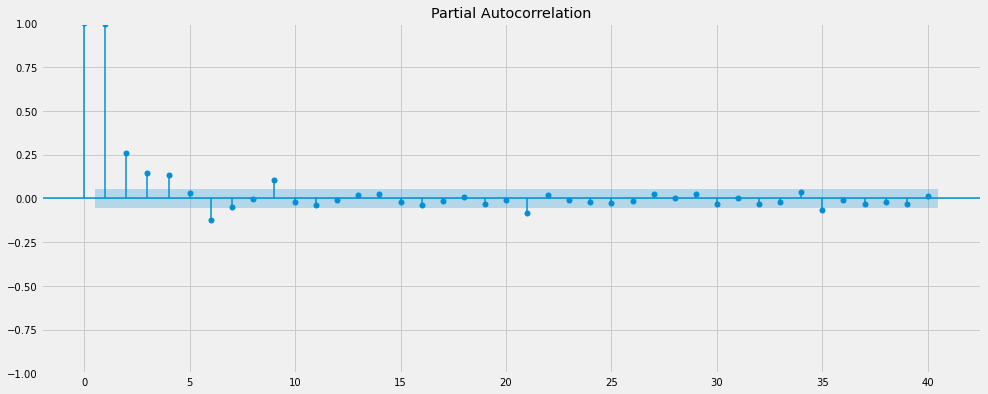

In [19]:
s=sm.graphics.tsa.plot_pacf(ts, lags=40, method="ywm")

In [20]:
from statsmodels.tsa.seasonal import STL

In [21]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series)
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)



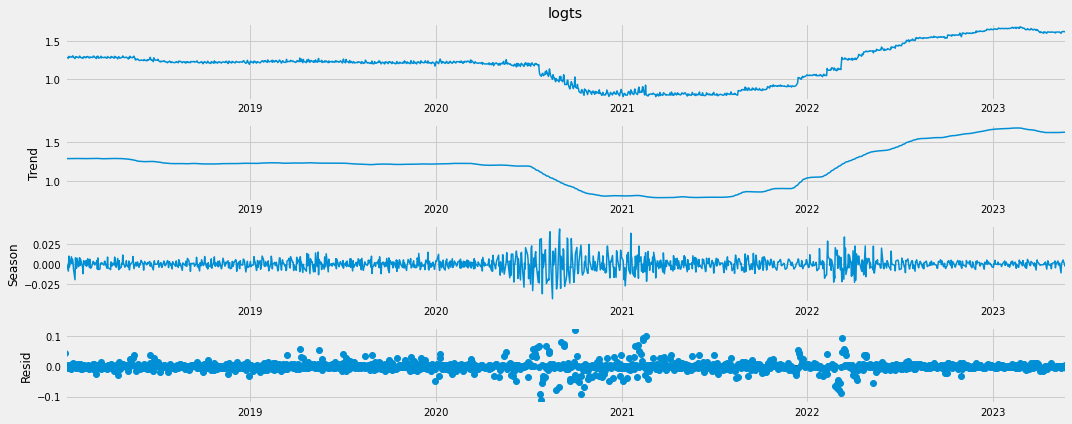

In [22]:
stl = STL(ts, period=12, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()

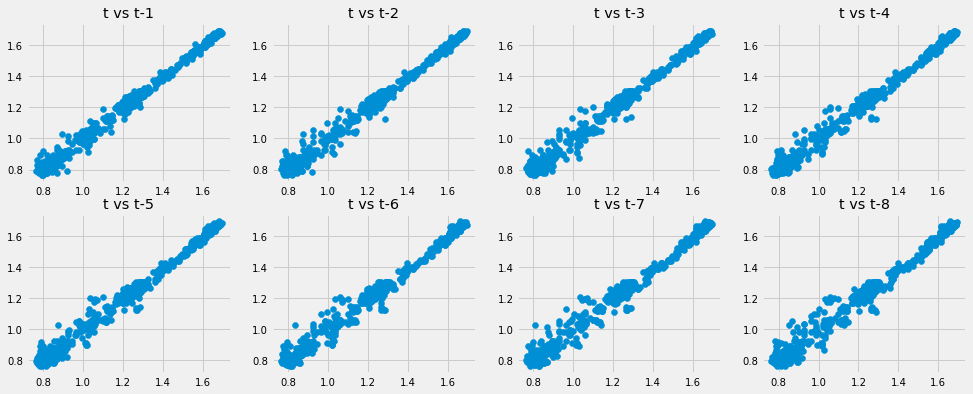

In [23]:
from pandas.plotting import scatter_matrix
values = pd.DataFrame(ts.values)
lags = 8
columns = [values]
for i in range(1,(lags + 1)):
    columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t']
for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)
for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t vs t-' + str(i))
    plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)
plt.show()

In [24]:
stocks1

,TIPOENTIDAD,CODIGOENTIDAD,NOMBREENTIDAD,FECHACORTE,TASA,MONTO
0,1,1,BANCO DE BOGOTA,2018-01-02,4.77,15784270.00
1,1,1,BANCO DE BOGOTA,2018-01-03,4.82,14664331.00
2,1,1,BANCO DE BOGOTA,2018-01-04,4.58,9616842.00
3,1,1,BANCO DE BOGOTA,2018-01-05,4.66,14426755.00
4,1,1,BANCO DE BOGOTA,2018-01-09,4.77,11691688.00
...,...,...,...,...,...,...
47009,32,5,CONFIAR COOPERATIVA FINANCIERA,2023-05-17,7.35,3167247.92
47010,32,5,CONFIAR COOPERATIVA FINANCIERA,2023-05-18,7.38,3739878.74
47011,32,5,CONFIAR COOPERATIVA FINANCIERA,2023-05-19,7.02,6256846.37
47012,32,5,CONFIAR COOPERATIVA FINANCIERA,2023-05-23,8.54,12458597.07


In [25]:
f, Pxx_den=scipy.signal.periodogram(ts)
plt.plot(f, Pxx_den)
plt.axvline(x=1/50,color='red')
max_index_value = np.argmax(Pxx_den, axis=0)
print(max_index_value)
frecuencia_max=f[max_index_value]
print(frecuencia_max)

NameError: name 'scipy' is not defined

In [26]:
bancolombia1 = stocks1.query("NOMBREENTIDAD == 'BANCOLOMBIA '")[["FECHACORTE","TASA"]]
bancolombia1 = bancolombia1[["FECHACORTE","TASA"]]
bancolombia1.set_index("FECHACORTE", inplace=True)
bancolombia1.index

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-15', '2018-01-16',
               ...
               '2023-05-10', '2023-05-11', '2023-05-12', '2023-05-15',
               '2023-05-16', '2023-05-17', '2023-05-18', '2023-05-19',
               '2023-05-23', '2023-05-24'],
              dtype='datetime64[ns]', name='FECHACORTE', length=1322, freq=None)

In [27]:
bancolombia1["year"] = bancolombia1.index.year
bancolombia1["month"] = bancolombia1.index.month
bancolombia1["week"] = bancolombia1.index.week

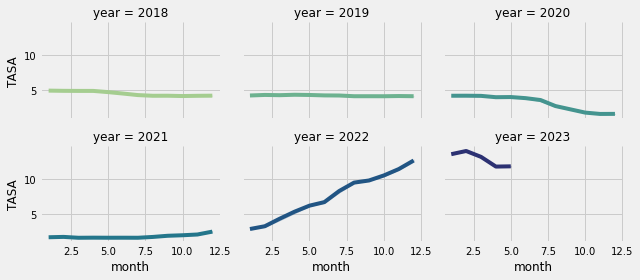

In [28]:
# Plot each year's time series in its own facet
g = sns.relplot(
    data=bancolombia1,
    x="month", y="TASA", col="year", hue="year",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

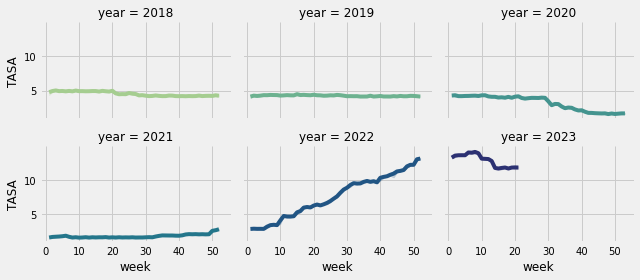

In [29]:
# Plot each year's time series in its own facet
g = sns.relplot(
    data=bancolombia1,
    x="week", y="TASA", col="year", hue="year",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

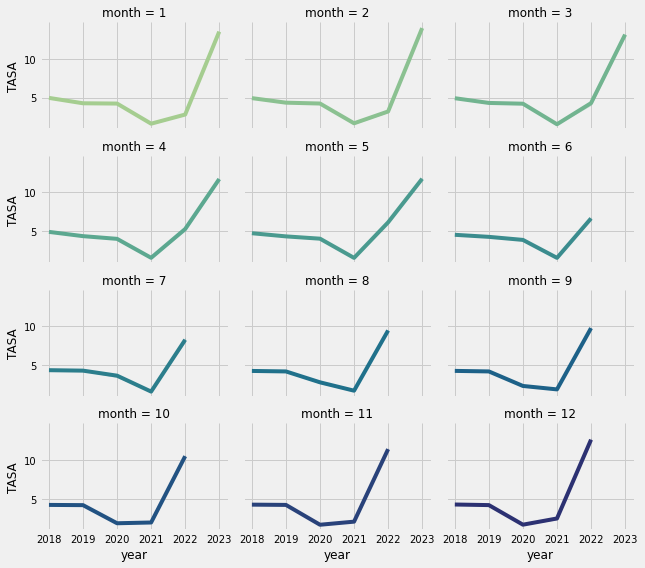

In [30]:
# Plot each year's time series in its own facet
g = sns.relplot(
    data=bancolombia1,
    x="year", y="TASA", col="month", hue="month",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

Text(0.5, 1.0, 'Histograma por tipo de entidad financiera')

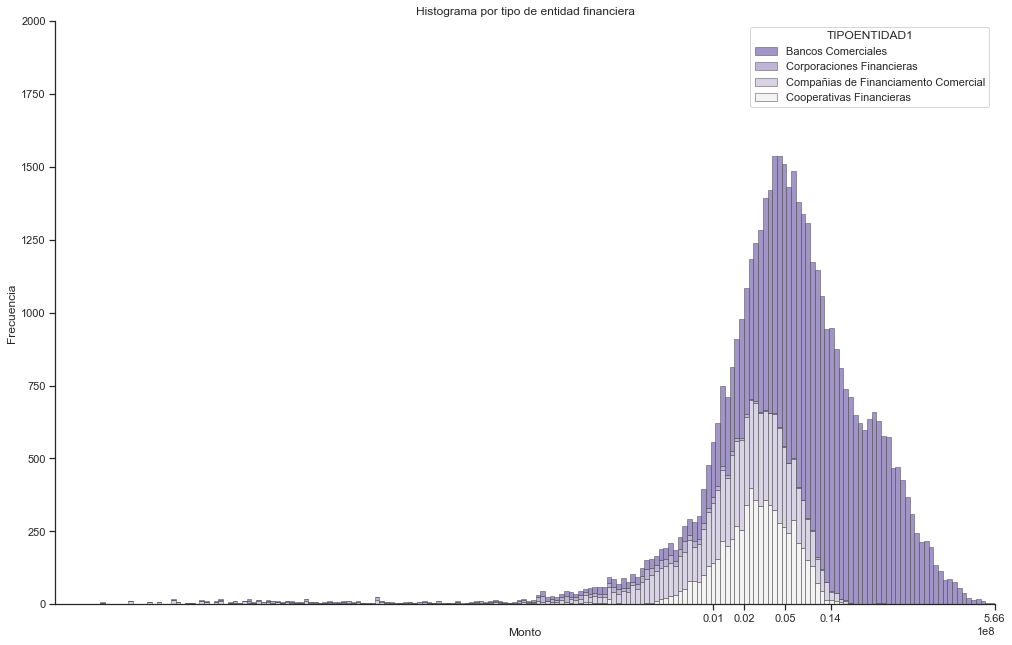

In [35]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
categorias = {
    1: 'Bancos Comerciales',
    2: 'Corporaciones Financieras',
    4: 'Compañias de Financiamento Comercial',
    32: 'Cooperativas Financieras'
}

# Enmascarar los valores numéricos a categóricos
stocks1['TIPOENTIDAD1'] = stocks1['TIPOENTIDAD'].map(categorias)
sns.set_theme(style="ticks")


f, ax = plt.subplots(figsize=(15, 10))
sns.despine(f)

sns.histplot(
    stocks1,
    x="MONTO", hue="TIPOENTIDAD1",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([1000000, 2000000 ,5000000 ,14000000 ,566000000])
ax.set_xlabel("Monto")
ax.set_ylabel("Frecuencia")
ax.set_xlim(0, 566000000)
ax.set_ylim(0, 2000)
ax.set_title("Histograma por tipo de entidad financiera")

## Mirar si se puede mostrar mas detallado

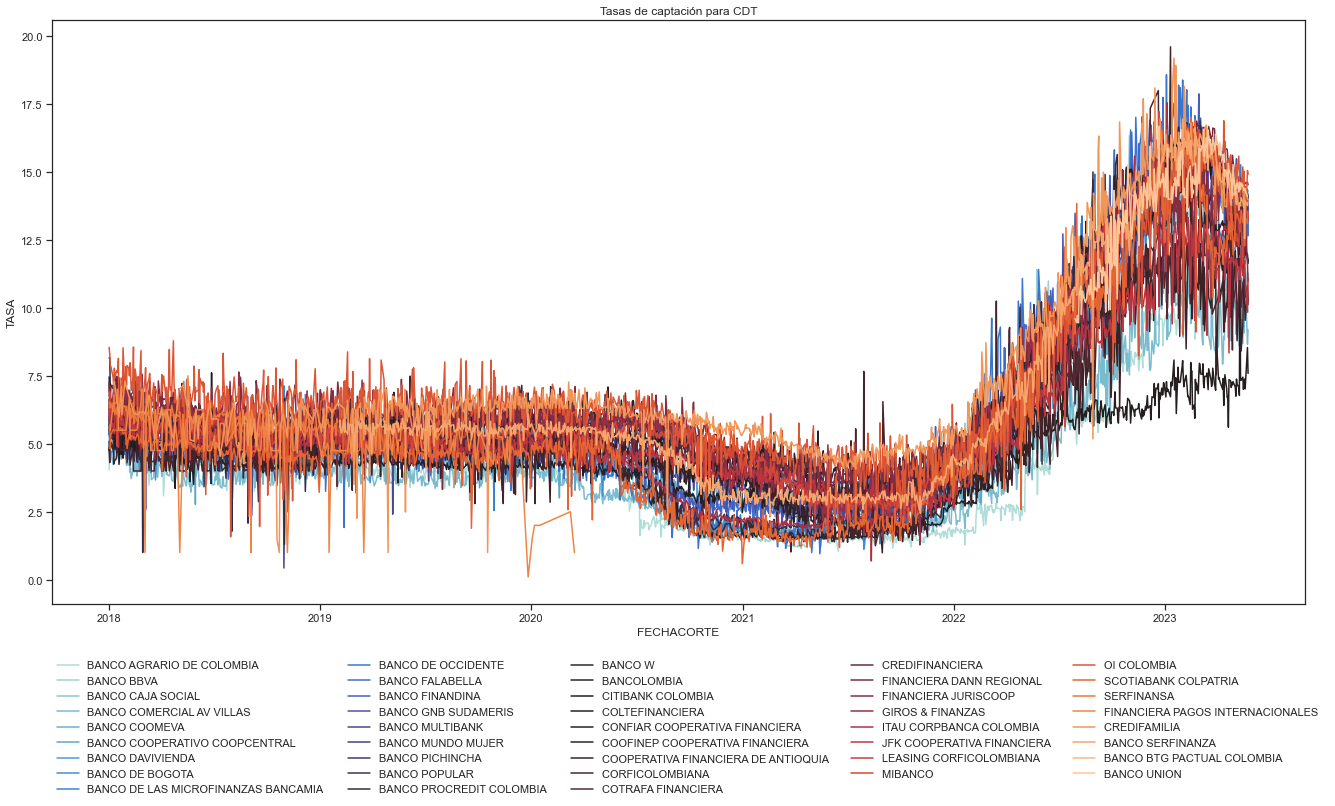

In [34]:
fig, ax = plt.subplots(1, 1, figsize =(20, 10))
sns.lineplot(x='FECHACORTE',y='TASA', palette="icefire",hue='NOMBREENTIDAD',data=(stocks1.groupby(['FECHACORTE', 'NOMBREENTIDAD']).TASA.mean().to_frame()))
ax.set_title("Tasas de captación para CDT")
sns.move_legend(ax, "upper left", bbox_to_anchor=(0, -0.09), borderaxespad=0, ncol=5, title=None, frameon=False);

## Tasa de captación por tipo de entidad

Text(0.5, 1.0, 'Tasas de captación para CDT')

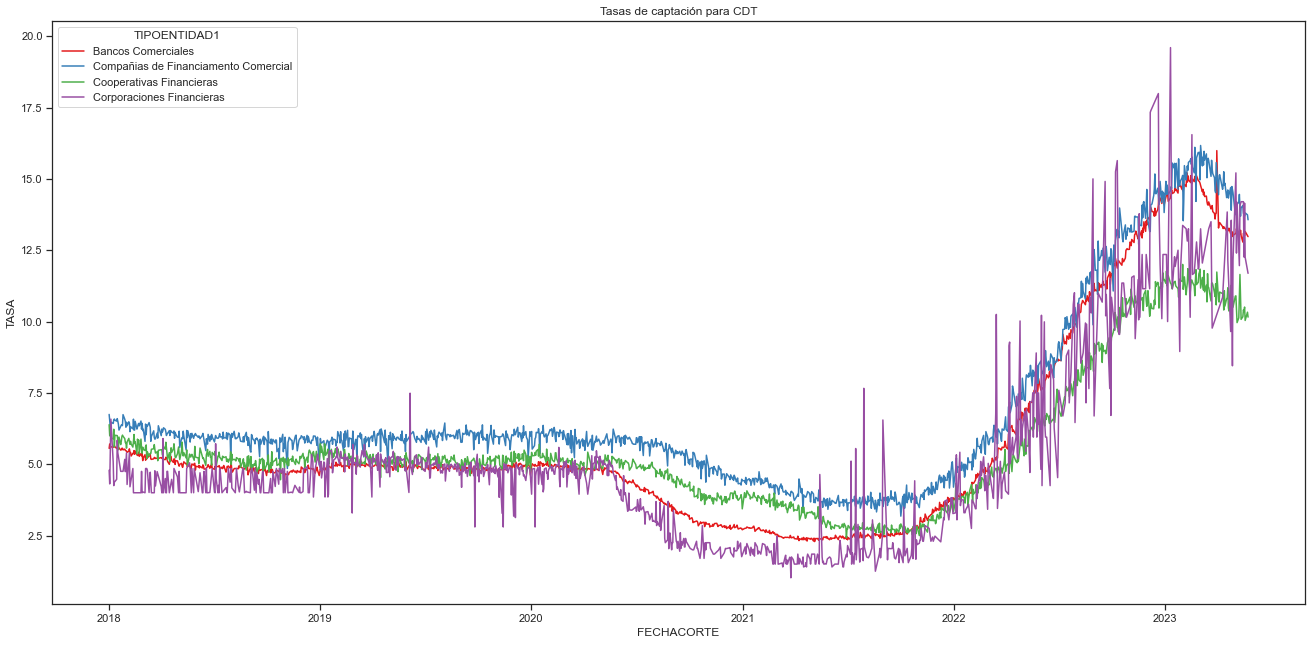

In [33]:
fig, ax = plt.subplots(1, 1, figsize= (20, 10))

sns.lineplot(x='FECHACORTE',y='TASA',hue='TIPOENTIDAD1',palette="Set1",data=(stocks1.groupby(['FECHACORTE', 'TIPOENTIDAD1']).TASA.mean().to_frame()))
ax.set_title("Tasas de captación para CDT")

## Kernels

Text(0.5, 1.0, 'Density plot for num_sold per country')

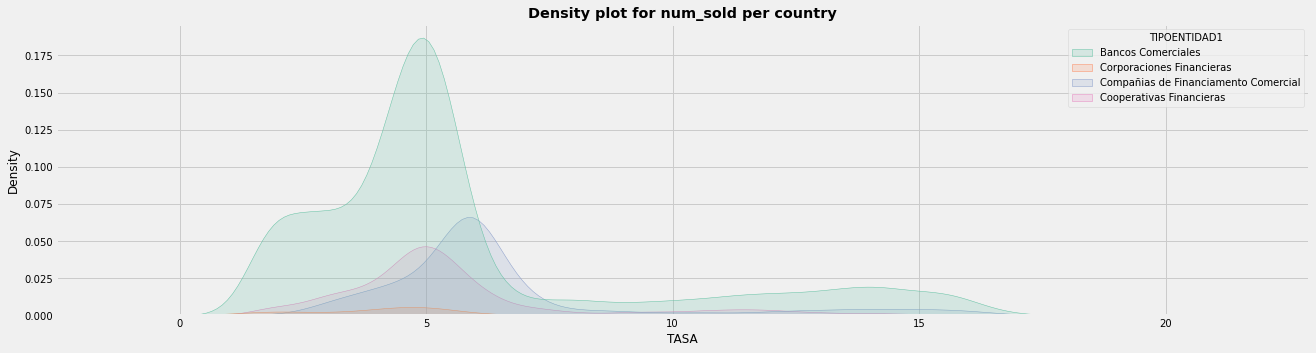

In [19]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))

sns.kdeplot(data=stocks1, x='TASA', hue = 'TIPOENTIDAD1', palette="Set2",fill=True, alpha = 0.2, ax = ax)
ax.set_title('Density plot for num_sold per country', fontweight = 'bold')

Text(0.5, 1.0, 'Density plot for num_sold per country')

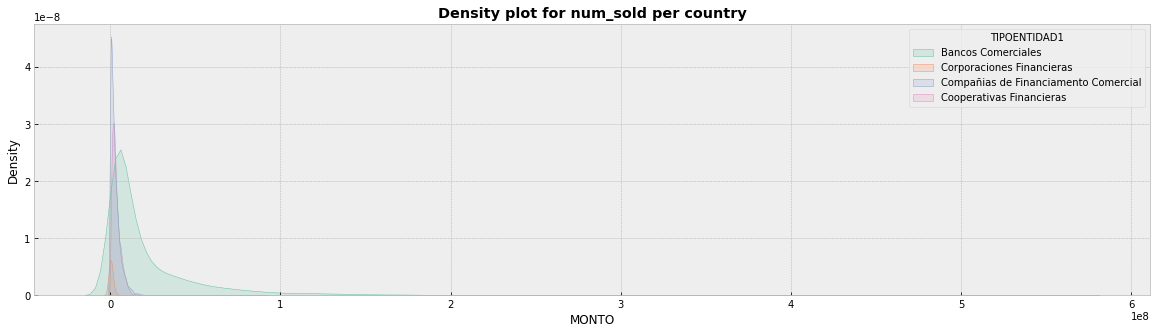

In [14]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))

sns.kdeplot(data=stocks1, x='MONTO', hue = 'TIPOENTIDAD1', palette="Set2",fill=True, alpha = 0.2, ax = ax)
ax.set_title('Density plot for num_sold per country', fontweight = 'bold')

<AxesSubplot:xlabel='TASA', ylabel='NOMBREENTIDAD'>

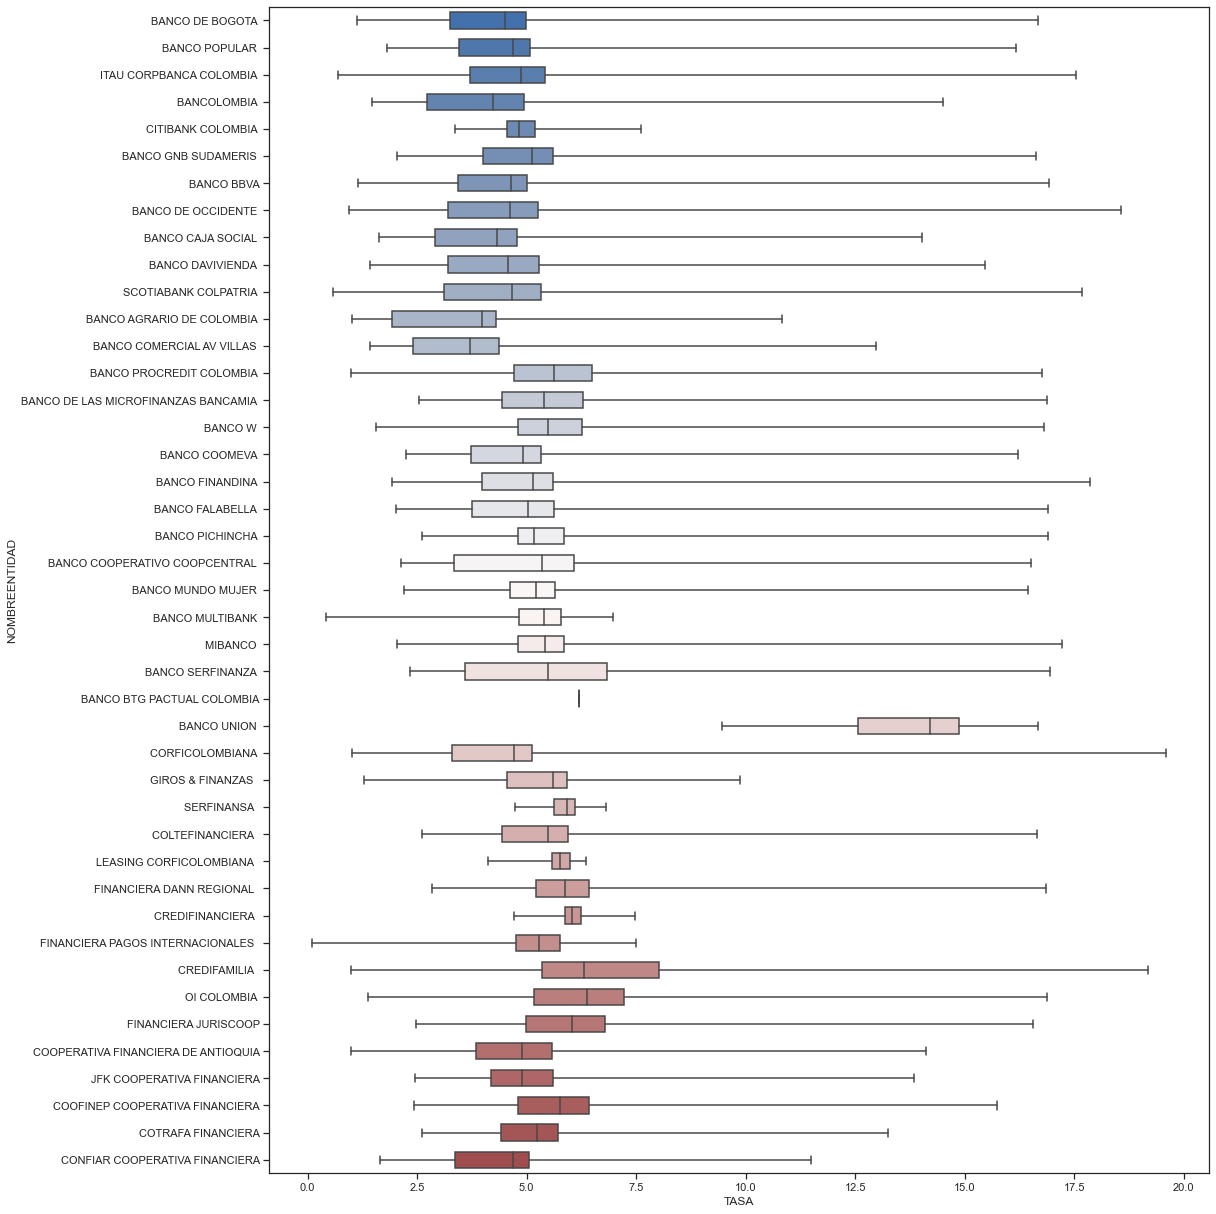

In [141]:
fig, ax = plt.subplots(1, 1, figsize = (15, 20))
sns.boxplot(x="TASA", y="NOMBREENTIDAD", data=stocks1,
            whis=[0, 100], width=.6, palette="vlag")

In [ ]:
type(stocks1)
stocks1

,CODIFICACION,TIPOENTIDAD,CODIGOENTIDAD,NOMBREENTIDAD,FECHACORTE,UCA,NOMBRE_UNIDAD_DE_CAPTURA,SUBCUENTA,DESCRIPCION,TASA,MONTO
0,4410101900,1,23,BANCO DE OCCIDENTE S.A.,2023-05-24,1,EMISIONES PUNTUALES Y RANGOS DE EMISION DE CDT,900,CAPTACIONES A TRAVES DE CDT POR RED DE OFICINAS,13.66,40300316.38
1,4410101900,32,5,CONFIAR COOPERATIVA FINANCIERA,2023-05-24,1,EMISIONES PUNTUALES Y RANGOS DE EMISION DE CDT,900,CAPTACIONES A TRAVES DE CDT POR RED DE OFICINAS,7.59,3395274.18
2,4410101900,4,108,FINANCIERA DANN REGIONAL S.A C.F,2023-05-24,1,EMISIONES PUNTUALES Y RANGOS DE EMISION DE CDT,900,CAPTACIONES A TRAVES DE CDT POR RED DE OFICINAS,14.52,3987327.87
3,4410101900,1,53,BANCO W S.A.,2023-05-24,1,EMISIONES PUNTUALES Y RANGOS DE EMISION DE CDT,900,CAPTACIONES A TRAVES DE CDT POR RED DE OFICINAS,13.89,3861029.37
4,4410101900,1,55,BANCO FINANDINA S.A.,2023-05-24,1,EMISIONES PUNTUALES Y RANGOS DE EMISION DE CDT,900,CAPTACIONES A TRAVES DE CDT POR RED DE OFICINAS,12.65,5312816.01
...,...,...,...,...,...,...,...,...,...,...,...
47009,4410101900,4,108,FINANCIERA DANN REGIONAL S.A C.F,2018-01-02,1,EMISIONES PUNTUALES Y RANGOS DE EMISION DE CDT,900,CAPTACIONES A TRAVES DE CDT POR RED DE OFICINAS,6.78,2249925.78
47010,4410101900,2,11,CORFICOLOMBIANA S.A.,2018-01-02,1,EMISIONES PUNTUALES Y RANGOS DE EMISION DE CDT,900,CAPTACIONES A TRAVES DE CDT POR RED DE OFICINAS,4.79,241.00
47011,4410101900,1,9,CITIBANK - COLOMBIA S.A.,2018-01-02,1,EMISIONES PUNTUALES Y RANGOS DE EMISION DE CDT,900,CAPTACIONES A TRAVES DE CDT POR RED DE OFICINAS,5.48,8325894.30
47012,4410101900,1,51,BANCO PROCREDIT COLOMBIA S.A.,2018-01-02,1,EMISIONES PUNTUALES Y RANGOS DE EMISION DE CDT,900,CAPTACIONES A TRAVES DE CDT POR RED DE OFICINAS,8.15,1756472.02


##Modelo

In [12]:
import copy
from pathlib import Path
import warnings
#!pip install pytorch_forecasting
#!pip install pytorch_lightning
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

import pytorch_forecasting 
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, encoders
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, MultiLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [8]:
df['FECHA'] = pd.to_datetime(df['FECHA'])
df['MES'] = df['FECHA'].apply(lambda x: str(x.month))
#df["time_idx"] = (df["FECHA"].dt.year * 365) + (df["FECHA"].dt.month * 12) + (df["FECHA"].dt.day)
#df["time_idx"] -= df["time_idx"].min()
df['time_idx'] = [i for i in range(1300)]
print(df['time_idx'])

max_prediction_length = 10
max_encoder_length = 10
training_cutoff = df["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="TASA",
    group_ids=["MES"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=['BANCO DE BOGOTA ', 'BANCO POPULAR ',
       'ITAU CORPBANCA COLOMBIA ', 'BANCO GNB SUDAMERIS ',
       'BANCO BBVA', 'BANCO DE OCCIDENTE ', 'BANCO CAJA SOCIAL ',
       'BANCO DAVIVIENDA ', 'SCOTIABANK COLPATRIA ',
       'BANCO AGRARIO DE COLOMBIA ', 'BANCO COMERCIAL AV VILLAS ',
       'BANCO DE LAS MICROFINANZAS BANCAMIA ', 'BANCO W ', 'BANCO COOMEVA ',
       'BANCO FINANDINA ', 'BANCO FALABELLA ', 'BANCO PICHINCHA ',
       'BANCO COOPERATIVO COOPCENTRAL ', 'BANCO MUNDO MUJER ', 'MIBANCO ',
       'COLTEFINANCIERA  ', 'FINANCIERA DANN REGIONAL  ', 'OI COLOMBIA ',
       'FINANCIERA JURISCOOP', 'COOPERATIVA FINANCIERA DE ANTIOQUIA',
       'JFK COOPERATIVA FINANCIERA', 'COOFINEP COOPERATIVA FINANCIERA',
       'COTRAFA FINANCIERA', 'CONFIAR COOPERATIVA FINANCIERA'],
    time_varying_unknown_reals=['TASA'],
    target_normalizer=GroupNormalizer(
        groups=['MES'], transformation="softplus"
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
    categorical_encoders={
        'S100': pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'I100':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'C100':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        'C101':pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True)
    }
)

validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

trainer = pl.Trainer(
    max_epochs=50, 
    gradient_clip_val=0.1,
    limit_train_batches=20,
    log_every_n_steps=10,
    callbacks=[lr_logger, early_stop_callback],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

compiled_model = torch.compile(tft)
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

3958       0
3959       1
3960       2
3961       3
3962       4
        ... 
5253    1295
5254    1296
5255    1297
5256    1298
5257    1299
Name: time_idx, Length: 1300, dtype: int64


/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/data/timeseries.py:1281: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 1 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__MES': '4'}]
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU avai

Number of parameters in network: 59.0k


INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 544   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 22.1 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 21.4 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [9]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

best_model_path

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


'/content/lightning_logs/version_0/checkpoints/epoch=49-step=700.ckpt'

In [10]:
val_prediction_results = best_tft.predict(val_dataloader, mode="raw", return_x=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


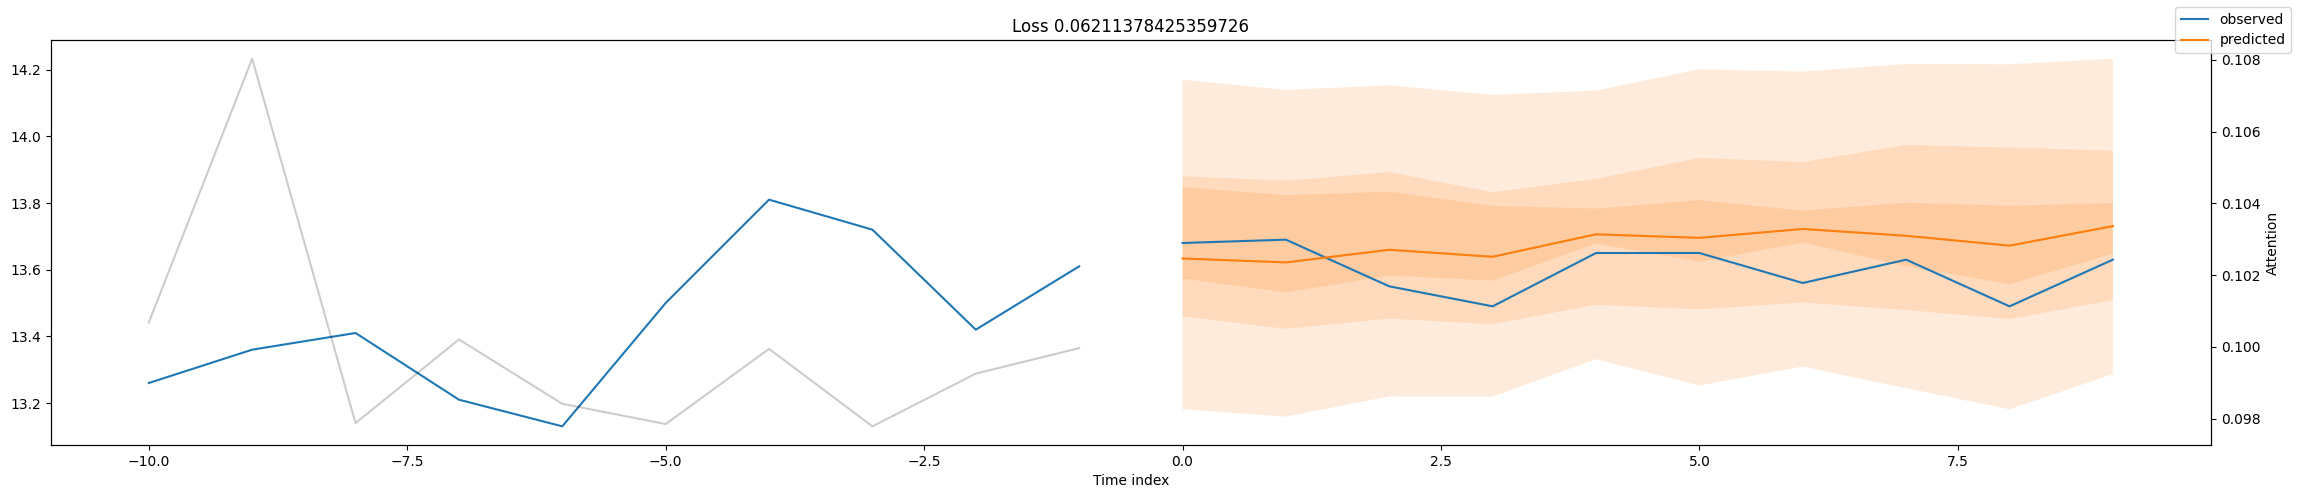

In [14]:
import matplotlib.pyplot as plt

for idx in range(1):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(val_prediction_results.x, # network input
                            val_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax);

In [ ]:
study = optimize_hyperparameters(
     train_dataloader,
     val_dataloader,
     model_path="optuna_test",
     n_trials=2,
     max_epochs=50,
     loss=QuantileLoss(),
     gradient_clip_val_range=(0.01, 1.0),
     hidden_size_range=(8, 128),
     hidden_continuous_size_range=(8, 128),
     attention_head_size_range=(1, 4),
     learning_rate_range=(0.001, 0.1),
     dropout_range=(0.1, 0.3),
     trainer_kwargs=dict(limit_train_batches=30),
     reduce_on_plateau_patience=4,
     use_learning_rate_finder=True,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# # pickle study results
with open("study.pkl", "wb") as fout:
     pickle.dump(study, fout)

# # show best hyperparameters
study.best_trial.params

In [ ]:
val_prediction_results = best_tft.predict(
    val_dataloader, 
    mode="prediction", # get only median predictions
    return_x=True,
    )
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(val_prediction_results.x, val_prediction_results.output)
features = list(set(predictions_vs_actuals['support'].keys())-set(['num_sold_lagged_by_365', 'num_sold_lagged_by_7']))
for feature in features:
    best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals, name=feature);